In [21]:
import torch
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
import torch
import torch.optim as optim

In [22]:
from model import Net
model = torch.load('model_weights/modelentire.pth')
model.load_state_dict(torch.load('model_weights/model.pth'))
loss_function = nn.MSELoss()
model.eval()

Net(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:
df = pd.read_pickle('Test_Dataset')
df

,Sigma,mu,d,th,th0,Decay
15067,-0.997694,0.239632,0.0,-1.224529,0.0,"[0.19710951874393856, 0.18686734402129945, 0.1..."
15441,0.702035,0.865774,0.0,1.501683,0.0,"[0.18729061178144052, 0.17607316033246334, 0.1..."
53512,-0.257575,1.301108,0.0,0.960704,0.0,"[0.19492830118742754, 0.18461371393381612, 0.1..."
55517,-0.439870,-0.182053,0.0,0.296815,0.0,"[0.18975509517206954, 0.17826619531626262, 0.1..."
18250,0.870267,-1.471396,0.0,-0.450235,0.0,"[0.16612494686759216, 0.14972489038879724, 0.1..."
...,...,...,...,...,...,...
69892,0.814175,0.781662,0.0,-0.878862,0.0,"[0.1882601086365116, 0.17643418646482018, 0.16..."
72626,-0.020505,-0.181898,0.0,-0.651101,0.0,"[0.18716586487573802, 0.17512817120621807, 0.1..."
17249,0.133407,1.380844,0.0,0.863656,0.0,"[0.1928662308439771, 0.18225947646392704, 0.17..."
38159,1.210575,-0.099357,0.0,1.416446,0.0,"[0.1803007929163741, 0.16759557921691812, 0.15..."


In [24]:
def weighted_mse(u_exp: np.ndarray, u: np.ndarray, time: np.ndarray, eps: float = + 10 ** (-15)) -> Tuple[np.ndarray, np.ndarray]:
    dt = np.diff(time, n=1, axis=0)
    dt = np.append(dt, dt[-1])
    amplitude = np.dot(dt, u * u_exp) / np.dot(dt, u ** 2)
    e = (u_exp - amplitude * u) / (u_exp + eps) * dt
    
    loss = np.dot(e, e)
#     if (np.log(loss) == math.inf):
#         print('u_exp\n', u_exp)
#         print('u\n', u)
#         print('amplitude = ', amplitude)
#         print ('loss = ', loss)
#         sys.exit()
    return loss, amplitude, e



t = 1e-3 * np.array([
    0.135, 0.180, 0.235, 0.315, 0.365, 0.420,
    0.485, 0.560, 0.650, 0.750, 0.865, 1.000,
    1.155, 1.335, 1.540, 1.780, 2.055, 2.370,
    2.740, 3.160, 3.650, 4.215, 4.870, 5.625,
    6.495, 7.500, 8.660, 10.00, 11.55, 13.34,
    15.40, 17.79, 20.54, 23.72, 27.39, 31.63,
    36.52, 42.17, 48.70, 56.24, 64.94, 74.99,
    86.60, 100.0, 115.5, 133.4
])

In [25]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()

def appending_to_tensor(tensor, rand_2_strs):
    tmp_tensor = torch.tensor([rand_2_strs.get('Sigma').iloc[0],rand_2_strs.get('Sigma').iloc[1],
                               rand_2_strs.get('mu').iloc[0],rand_2_strs.get('mu').iloc[1],
                               rand_2_strs.get('th').iloc[0],rand_2_strs.get('th').iloc[1],
                               np.log(weighted_mse(np.array(rand_2_strs.get('Decay').iloc[0]),np.array(rand_2_strs.get('Decay').iloc[1]),t)[0])])
    tmp_tensor = torch.unsqueeze(tmp_tensor, 0)
    tmp_tensor = torch.cat((tensor,tmp_tensor),0)
    return(tmp_tensor)

def mean_absolute_percentage_error(y_pred, y_true, eps=10**(-2)): 
    return abs(torch.mean(((y_true-y_pred))/(y_true + eps)))*100


def create_batches_to_device(df, device, batch_size=128):
    tensor = torch.tensor([])
    for i in range (batch_size):
        rand_train_str = df.sample(2)
        tensor = appending_to_tensor(tensor, rand_train_str)
    tensor = tensor.to(device)
    trainset = torch.utils.data.DataLoader(tensor, batch_size=batch_size, shuffle=True)
    return (trainset)
print(device)

cpu


In [35]:
net = model.double().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
df_mape_loss = []
import time
from tqdm import tqdm
batch = 1000
for i in tqdm(range(batch)):
    data_batch = create_batches_to_device(df, device, batch_size=1)
    for data in data_batch:
        X = data[:, 0:-1]
        y = data[:,-1]
        output = net(X.double())
        loss = loss_function(output.view(-1), y)
    mape = mean_absolute_percentage_error(output.view(-1), y)
    df_mape_loss.append(mape.item())
    batch = batch + 1

100%|██████████| 1000/1000 [00:01<00:00, 764.36it/s]


In [36]:
print(len(df_mape_loss))
lol = pd.DataFrame(data=df_mape_loss, columns=["Ошибка сети в %"])
lol.to_pickle('Mape_for_hist')

1000


In [37]:
hist_df = pd.read_pickle('Mape_for_hist')
hist_df

,Ошибка сети в %
0,6.294092
1,0.208115
2,1.041998
3,10.226533
4,0.319872
...,...
995,0.847514
996,5.810712
997,3.612044
998,1.070886


In [46]:
negative_hist_df = -hist_df
negative_hist_df

,Ошибка сети в %
0,-6.294092
1,-0.208115
2,-1.041998
3,-10.226533
4,-0.319872
...,...
995,-0.847514
996,-5.810712
997,-3.612044
998,-1.070886


In [50]:
total_concat = [hist_df, negative_hist_df]
total_concat = pd.concat(total_concat,ignore_index=True)
total_concat

,Ошибка сети в %
0,6.294092
1,0.208115
2,1.041998
3,10.226533
4,0.319872
...,...
1995,-0.847514
1996,-5.810712
1997,-3.612044
1998,-1.070886


In [52]:
k2, p = stats.normaltest(total_concat['Ошибка сети в %'].values)
p

2.275074148931357e-216

In [55]:
shapiro_test = stats.shapiro(total_concat['Ошибка сети в %'].values)
shapiro_test

ShapiroResult(statistic=0.16558688879013062, pvalue=0.0)

## Проверка на нормальность

### D’Agostino-Pearson

In [38]:
from scipy import stats

In [39]:
k2, p = stats.normaltest(hist_df['Ошибка сети в %'].values)
p

0.0

### Shapiro

In [40]:
shapiro_test = stats.shapiro(hist_df['Ошибка сети в %'].values)
shapiro_test


ShapiroResult(statistic=0.1262671947479248, pvalue=0.0)

## Оценка уровня статистической значимости

In [57]:
fig = px.histogram(hist_df, x="Ошибка сети в %", nbins=1000, histnorm="percent")
fig.update_xaxes(range=[0, 7])
fig.update_layout(title="Распределение ошибок нейросетевой оценки параметра Т",
                  xaxis_title="Относительная ошибка (MAPE), %",
                  yaxis_title="Доля выборки, %"
                 )
fig.show()

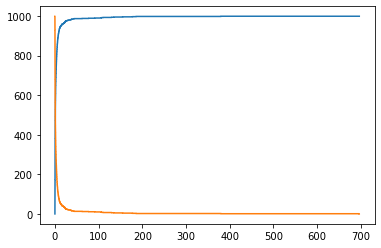

In [45]:
import matplotlib.pyplot as plt
sorted_data = np.sort(hist_df['Ошибка сети в %'].values) 
# Cumulative counts:
plt.step(sorted_data, np.arange(sorted_data.size))  # From 0 to the number of data points-1
plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

plt.show()

### График Decay(время)

In [13]:
rand_str = df.sample(2)
rand_1_str = rand_str[['Decay']].iloc[0]
rand_2_str = rand_str[['Decay']].iloc[1]
#На всякий случай сохраним это в DF
df_2_str = pd.DataFrame({'Decay1':rand_1_str.values[0], 'Decay2':rand_2_str.values[0], 'Time':t})
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=rand_1_str.values[0],
                    mode='lines',
                    name='Decay1'))
fig.add_trace(go.Scatter(x=t, y=rand_2_str.values[0],
                    mode='lines',
                    name='Decay2'))
fig.update_yaxes(type="log")
fig.update_xaxes(range=[0, 0.12])

fig.update_layout(title="Величина отклика (Decay) от времени",
                  xaxis_title="Время, с",
                  yaxis_title="Отклик, мВ",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

loss, _, c = weighted_mse(np.array(rand_str.get('Decay').iloc[0]),np.array(rand_str.get('Decay').iloc[1]),t)
print('total loss = ', loss)
fig = go.Figure(data=go.Scatter(x=t, y=c))
#fig.update_yaxes(range=[-0.01, 0.01])
fig.update_xaxes(range=[0, 0.12])
fig.update_layout(title="Loss отликов (Decay) для каждого момента времени",
                  xaxis_title="Время, с",
                  yaxis_title="loss",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

NameError: name 'df' is not defined